# Hand Gesture Recognition

Uses CNN to generate hand gesture recognition model that identifies preset gestures (i.e. OK, Palm)

Coded from [https://towardsdatascience.com/tutorial-using-deep-learning-and-cnns-to-make-a-hand-gesture-recognition-model-371770b63a51](https://towardsdatascience.com/tutorial-using-deep-learning-and-cnns-to-make-a-hand-gesture-recognition-model-371770b63a51)

## Training

Train model using data from [Hand Gesture Recognition Database](https://www.kaggle.com/gti-upm/leapgestrecog/version/1) from Kaggle. The dataset consists of 20,000 images of 10 gestures made by 10 different people.

In [32]:

# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.3.0


In [33]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk("./leapGestRecog", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

20000


In [24]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


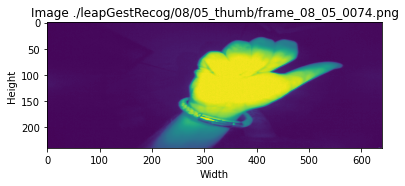

In [25]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [26]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20000
Labels loaded:  20000
5 ./leapGestRecog/08/05_thumb/frame_08_05_0074.png


In [27]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

## Create Model

Set up Convolutional Neural Network model and layers using Keras from Tensorflow

In [28]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [29]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [30]:

# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [31]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
219/219 - 872s - loss: 0.4425 - accuracy: 0.9392 - val_loss: 0.0051 - val_accuracy: 0.9987
Epoch 2/5
219/219 - 866s - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0153 - val_accuracy: 0.9968
Epoch 3/5
219/219 - 864s - loss: 0.0226 - accuracy: 0.9934 - val_loss: 0.0124 - val_accuracy: 0.9960
Epoch 4/5
219/219 - 862s - loss: 0.0108 - accuracy: 0.9978 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 5/5
219/219 - 862s - loss: 9.2103e-04 - accuracy: 0.9999 - val_loss: 6.5849e-04 - val_accuracy: 0.9998


In [34]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

## Results

In [35]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 [==============================] - 94s 500ms/step - loss: 6.5849e-04 - accuracy: 0.9998
Test accuracy: 99.98%


In [36]:
predictions = model.predict(X_test)

In [37]:
np.argmax(predictions[0]), y_test[0]

(0, 0)

In [38]:
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"]
  plt.figure(figsize=(15,5))

  for i in range(1, 10):
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Plot
    plt.subplot(3, 3, i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction)

    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                                          100 * np.max(prediction),
                                                          class_names[true_label]),
               color=color)
  plt.show()

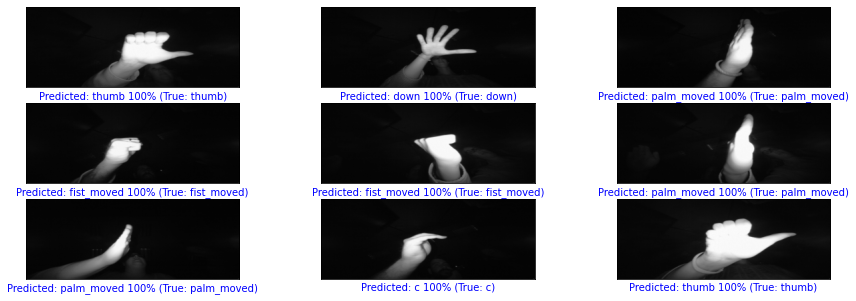

In [39]:
validate_9_images(predictions, y_test, X_test)

In [40]:
y_pred = np.argmax(predictions, axis=1)   # Transform predictions into 1-D array with label number

In [41]:
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,591,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,568,0,0,0,0,0,0,0,0
Actual L,0,0,585,0,0,0,1,0,0,0
Actual Fist (H),0,0,0,618,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,604,0,0,0,0,0
Actual Thumbs up,0,0,0,0,0,605,0,0,0,0
Actual Index,0,0,0,0,0,0,611,0,0,0
Actual OK,0,0,0,0,0,0,0,600,0,0
Actual Palm (V),0,0,0,0,0,0,0,0,596,0
Actual C,0,0,0,0,0,0,0,0,0,621
